# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import fairsim as spdata
from fairsim import sp_plot
import itertools as itert

/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/smb/Documents/code/detect_simpsons_paradox_dev/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,15.139436,15.583219,7.697521,5.141548,17.630523,12.426590,A2,B1,C3
1,13.454187,16.794068,11.801131,11.032036,14.727922,15.523285,A2,B0,C3
2,7.418924,9.010794,11.822644,10.735995,15.690291,13.433675,A1,B0,C3
3,13.856916,13.529922,12.504783,10.405526,12.156896,9.859766,A0,B0,C0
4,8.372348,8.460485,11.518037,11.416532,11.412748,10.157467,A1,B0,C0


We'll also plot them in the dimensions where we added SP

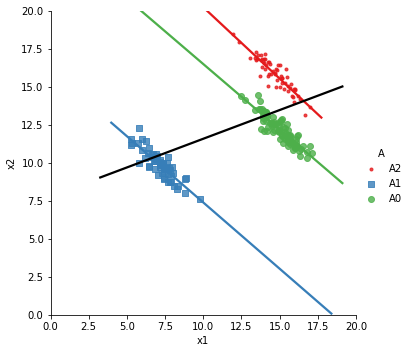

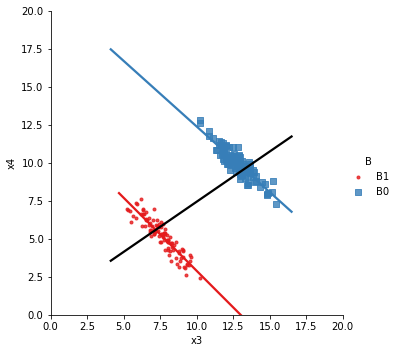

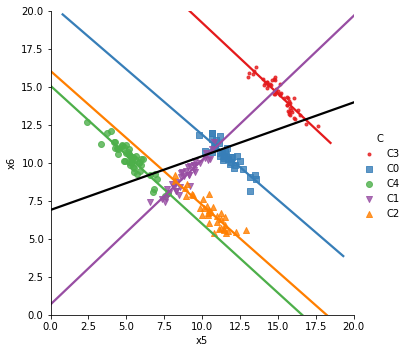

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.551862,x1,x2,-0.897276,A,A0,True
1,-0.047618,x1,x3,0.005512,A,A0,False
2,-0.081491,x1,x4,0.088945,A,A0,False
3,0.015121,x1,x5,-0.135180,A,A0,False
4,0.039489,x1,x6,-0.022782,A,A0,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    53
True      9
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

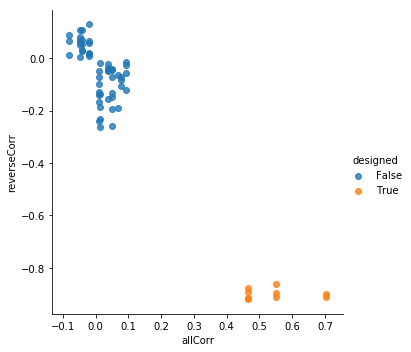

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,53.0,0.011094,0.049817,-0.081491,-0.041573,0.010518,0.051301,0.094414
True,9.0,0.547159,0.097492,0.465258,0.465258,0.551862,0.551862,0.703908


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module that compute the slopes of each subgroup trend and the overall trend lines. 

In [8]:
results_df_slopes = dsp.add_slope_cols(many_sp_df_diff, many_sp_df_diff_result)

results_df_slopes

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966
2,0.015121,x1,x5,-0.185700,C,C0,False,-0.044791,0.014966
3,0.015121,x1,x5,-0.261322,C,C2,False,-0.076913,0.014966
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378
7,0.010518,x3,x6,-0.139772,B,B1,False,-0.334690,0.010378
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378


For ranking, looking at the angle between is most interesting

In [9]:

results_df_slopes = dsp.add_angle_col(results_df_slopes)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729
2,0.015121,x1,x5,-0.185700,C,C0,False,-0.044791,0.014966,3.422062
3,0.015121,x1,x5,-0.261322,C,C2,False,-0.076913,0.014966,5.255569
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966,4.511243


Then, to rank, we can sort by various values

In [10]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
15,0.703908,x3,x4,-0.910096,B,B1,True,-0.961597,0.660486,77.322612
14,0.703908,x3,x4,-0.898768,B,B0,True,-0.863327,0.660486,74.249113
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931
7,0.010518,x3,x6,-0.139772,B,B1,False,-0.334690,0.010378,19.099433
16,0.067370,x4,x5,-0.062210,B,B0,False,-0.242612,0.093200,18.961729
18,0.094414,x3,x5,-0.024403,B,B1,False,-0.075128,0.122557,11.283565
19,0.094414,x3,x5,-0.119260,C,C0,False,-0.043525,0.122557,9.479364
17,0.067370,x4,x5,-0.191293,C,C1,False,-0.071727,0.093200,9.427199
22,0.077312,x2,x5,-0.107021,C,C0,False,-0.036680,0.111863,8.483449
23,0.077312,x2,x5,-0.082076,C,C2,False,-0.036074,0.111863,8.448741


In [11]:
results_df_slopes.sort_values('allCorr',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
15,0.703908,x3,x4,-0.910096,B,B1,True,-0.961597,0.660486,77.322612
14,0.703908,x3,x4,-0.898768,B,B0,True,-0.863327,0.660486,74.249113
21,0.094414,x3,x5,-0.014122,C,C4,False,-0.005181,0.122557,7.283950
20,0.094414,x3,x5,-0.055678,C,C1,False,-0.019985,0.122557,8.132060
19,0.094414,x3,x5,-0.119260,C,C0,False,-0.043525,0.122557,9.479364
18,0.094414,x3,x5,-0.024403,B,B1,False,-0.075128,0.122557,11.283565
24,0.077312,x2,x5,-0.069758,C,C3,False,-0.025981,0.111863,7.871041
23,0.077312,x2,x5,-0.082076,C,C2,False,-0.036074,0.111863,8.448741
22,0.077312,x2,x5,-0.107021,C,C0,False,-0.036680,0.111863,8.483449
17,0.067370,x4,x5,-0.191293,C,C1,False,-0.071727,0.093200,9.427199


We can also compare how each occurence ranks by different variables. 

In [12]:
results_df_slopes.rank(numeric_only=True).head(10)

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
0,12.0,10.0,12.0,3.0,12.0,23.0
1,12.0,22.0,12.0,13.0,12.0,7.0
2,12.0,7.0,12.0,15.0,12.0,5.0
3,12.0,3.0,12.0,9.0,12.0,9.0
4,12.0,5.0,12.0,12.0,12.0,8.0
5,6.0,11.0,12.0,6.0,6.0,14.0
6,6.0,14.0,12.0,7.0,6.0,11.0
7,6.0,9.0,12.0,4.0,6.0,22.0
8,6.0,16.0,12.0,19.0,6.0,4.0
9,6.0,4.0,12.0,8.0,6.0,10.0


We can look at the spearman correlation of the various features.  THis is equic

In [13]:
results_df_slopes.corr(method='spearman')

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
allCorr,1.000000,-0.178216,0.478913,-0.180958,1.000000,0.685839
reverseCorr,-0.178216,1.000000,-0.470270,0.687692,-0.178216,-0.383077
designed,0.478913,-0.470270,1.000000,-0.470270,0.478913,0.470270
subgroup_slope,-0.180958,0.687692,-0.470270,1.000000,-0.180958,-0.674615
all_slope,1.000000,-0.178216,0.478913,-0.180958,1.000000,0.685839
angle,0.685839,-0.383077,0.470270,-0.674615,0.685839,1.000000


In [14]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,23.0,6.909627,8.454548,-17.604493,4.058060,7.283950,8.955324,27.237931
True,2.0,75.785863,2.173292,74.249113,75.017488,75.785863,76.554237,77.322612


In [15]:
results_df_slopes.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,23.0,0.034683,0.043437,-0.047927,0.010518,0.015121,0.077312,0.094414
True,2.0,0.703908,0.000000,0.703908,0.703908,0.703908,0.703908,0.703908


# View Ranking

For vizualization, we actually need to rank the views, where a view is defined by two attributes (to be used for x and y axes) and a colored view is defined by a triplet (attr1, attr2, groupby).

First, we'll look at the views , then different ways of ranking them. and finally ways to rank the occurences for highlighting within the view.  

The views show how many different plots of the data we would need to look at to see the SP occurences. 

In [16]:
dsp.get_SP_views(results_df_slopes)

[('x3', 'x5'),
 ('x1', 'x5'),
 ('x2', 'x4'),
 ('x2', 'x5'),
 ('x3', 'x4'),
 ('x4', 'x5'),
 ('x3', 'x6')]

Colored views show how many different colorings we should plot to see the SP (colring the samples by groupby attribute and adding trendlines for each color)

In [17]:
dsp.get_SP_colored_views(results_df_slopes)

[('x3', 'x5', 'B'),
 ('x2', 'x4', 'A'),
 ('x1', 'x5', 'C'),
 ('x3', 'x6', 'B'),
 ('x4', 'x5', 'B'),
 ('x3', 'x6', 'A'),
 ('x3', 'x4', 'B'),
 ('x2', 'x5', 'C'),
 ('x2', 'x4', 'B'),
 ('x4', 'x5', 'C'),
 ('x3', 'x6', 'C'),
 ('x3', 'x5', 'C'),
 ('x1', 'x5', 'A')]

To rank by views we need some sort of statistic for each of them.  First we will look at the number and portion of possible occurences for each view.  That is for how many groupby attributes does a view have SP or values of the groupby attribute does a colored view have SP, numerially and as a percentage in both cases

In [18]:
view_df = dsp.count_sp_views(results_df_slopes)
view_df

,attr1,attr2,SP_subgroups
0,x1,x5,5
1,x2,x4,2
2,x2,x5,3
3,x3,x4,2
4,x3,x5,4
5,x3,x6,7
6,x4,x5,2


And we can also do this for colored views

In [19]:
colored_view_df = dsp.count_sp_views(results_df_slopes,colored= True)
colored_view_df 

,attr1,attr2,groupbyAttr,SP_subgroups
0,x1,x5,A,2
1,x1,x5,C,3
2,x2,x4,A,1
3,x2,x4,B,1
4,x2,x5,C,3
5,x3,x4,B,2
6,x3,x5,B,1
7,x3,x5,C,3
8,x3,x6,A,2
9,x3,x6,B,1


We can further look at the portion of the possible subgroups for colored views that have SP.  The poriton for non colored views is less meaningful, so we don't offer a means to compute it. This requires botht the results and the 
koriginal data, to get the number of possible levels. 

In [20]:
colored_view_df  = dsp.count_sp_views(results_df_slopes,colored= True,portions=True, data_df=many_sp_df_diff)
colored_view_df 

,attr1,attr2,groupbyAttr,SP_subgroups,portions
0,x1,x5,A,2,0.666667
1,x1,x5,C,3,0.600000
2,x2,x4,A,1,0.333333
3,x2,x4,B,1,0.500000
4,x2,x5,C,3,0.600000
5,x3,x4,B,2,1.000000
6,x3,x5,B,1,0.500000
7,x3,x5,C,3,0.600000
8,x3,x6,A,2,0.666667
9,x3,x6,B,1,0.500000


Finally, we can add these stats about the view to the dataframe of the occurences

In [21]:
result_df_views = dsp.add_view_count(results_df_slopes,view_df)
result_df_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931,5
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729,5
2,0.015121,x1,x5,-0.185700,C,C0,False,-0.044791,0.014966,3.422062,5
3,0.015121,x1,x5,-0.261322,C,C2,False,-0.076913,0.014966,5.255569,5
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966,4.511243,5
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378,7.912041,7
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378,6.752871,7
7,0.010518,x3,x6,-0.139772,B,B1,False,-0.334690,0.010378,19.099433,7
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,7
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,7


In [22]:
result_df_colored_views = dsp.add_view_count(results_df_slopes,colored_view_df ,colored=True)
result_df_colored_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,portions
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931,2,0.666667
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729,2,0.666667
2,0.015121,x1,x5,-0.185700,C,C0,False,-0.044791,0.014966,3.422062,3,0.600000
3,0.015121,x1,x5,-0.261322,C,C2,False,-0.076913,0.014966,5.255569,3,0.600000
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966,4.511243,3,0.600000
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378,7.912041,2,0.666667
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378,6.752871,2,0.666667
7,0.010518,x3,x6,-0.139772,B,B1,False,-0.334690,0.010378,19.099433,1,0.500000
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,4,0.800000
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,4,0.800000


Now we can sort and examine views based on these counts.

In [23]:
result_df_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,7
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,7
11,0.010518,x3,x6,-0.047019,C,C4,False,-0.017084,0.010378,1.573311,7
10,0.010518,x3,x6,-0.166952,C,C3,False,-0.055748,0.010378,3.785391,7
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378,7.912041,7
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378,6.752871,7
7,0.010518,x3,x6,-0.139772,B,B1,False,-0.334690,0.010378,19.099433,7
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729,5
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931,5
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966,4.511243,5


In [24]:
result_df_colored_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,portions
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,4,0.8
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,4,0.8
10,0.010518,x3,x6,-0.166952,C,C3,False,-0.055748,0.010378,3.785391,4,0.8
11,0.010518,x3,x6,-0.047019,C,C4,False,-0.017084,0.010378,1.573311,4,0.8
24,0.077312,x2,x5,-0.069758,C,C3,False,-0.025981,0.111863,7.871041,3,0.6
2,0.015121,x1,x5,-0.185700,C,C0,False,-0.044791,0.014966,3.422062,3,0.6
3,0.015121,x1,x5,-0.261322,C,C2,False,-0.076913,0.014966,5.255569,3,0.6
4,0.015121,x1,x5,-0.229881,C,C3,False,-0.063857,0.014966,4.511243,3,0.6
23,0.077312,x2,x5,-0.082076,C,C2,False,-0.036074,0.111863,8.448741,3,0.6
22,0.077312,x2,x5,-0.107021,C,C0,False,-0.036680,0.111863,8.483449,3,0.6


In [25]:
result_df_colored_views.sort_values(by='portions',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,portions
15,0.703908,x3,x4,-0.910096,B,B1,True,-0.961597,0.660486,77.322612,2,1.000000
14,0.703908,x3,x4,-0.898768,B,B0,True,-0.863327,0.660486,74.249113,2,1.000000
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,4,0.800000
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,4,0.800000
10,0.010518,x3,x6,-0.166952,C,C3,False,-0.055748,0.010378,3.785391,4,0.800000
11,0.010518,x3,x6,-0.047019,C,C4,False,-0.017084,0.010378,1.573311,4,0.800000
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931,2,0.666667
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378,7.912041,2,0.666667
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378,6.752871,2,0.666667
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729,2,0.666667


From this, we see that the colored views captures the designed cases and the portions captures them better, but the views alone does not. 

# Mixed Severity and View Ranking

We can create combined scores that include occurence severity stats(angle, correlation) and view count stats

In [26]:
std_weights = {'reverseCorr':.25,
              'angle':.25,
              'portions':.5}
mix_rank_std = dsp.add_weighted(result_df_colored_views,std_weights,name='std_wt').sort_values(by='std_wt',ascending=False)
mix_rank_std

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,portions,std_wt
15,0.703908,x3,x4,-0.910096,B,B1,True,-0.961597,0.660486,77.322612,2,1.000000,0.750000
14,0.703908,x3,x4,-0.898768,B,B0,True,-0.863327,0.660486,74.249113,2,1.000000,0.744688
11,0.010518,x3,x6,-0.047019,C,C4,False,-0.017084,0.010378,1.573311,4,0.800000,0.637494
8,0.010518,x3,x6,-0.073328,C,C1,False,-0.026794,0.010378,2.129392,4,0.800000,0.632496
10,0.010518,x3,x6,-0.166952,C,C3,False,-0.055748,0.010378,3.785391,4,0.800000,0.613862
9,0.010518,x3,x6,-0.241103,C,C2,False,-0.091646,0.010378,5.830886,4,0.800000,0.601036
0,0.015121,x1,x5,-0.135180,A,A0,False,-0.495980,0.014966,27.237931,2,0.666667,0.600097
1,0.015121,x1,x5,-0.018139,A,A2,False,-0.060694,0.014966,4.330729,2,0.666667,0.568516
6,0.010518,x3,x6,-0.097263,A,A2,False,-0.107898,0.010378,6.752871,2,0.666667,0.555461
5,0.010518,x3,x6,-0.130542,A,A1,False,-0.128413,0.010378,7.912041,2,0.666667,0.550340


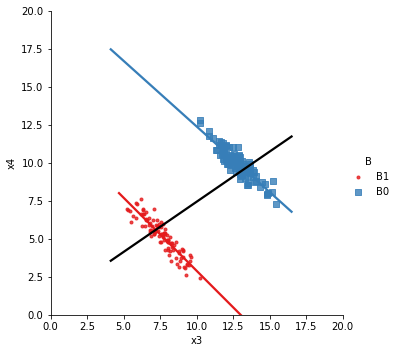

In [28]:
top_view = tuple(mix_rank_std[['attr1','attr2','groupbyAttr']].iloc[0])
sp_plot(many_sp_df_diff,*top_view)

THis ranks occurences, but we should also combine to rankthe views only, since that's what the actual figures will be. 

In [27]:

'_'.join([str(w) + c for c,w, in std_weights.items()])

'0.25reverseCorr_0.25angle_0.5portions'

In [28]:
list(std_weights.values())

[0.25, 0.25, 0.5]

In [29]:
result_df_colored_views[['angle','reverseCorr']] -result_df_colored_views[['angle','reverseCorr']].min()

,angle,reverseCorr
0,46.589520,0.855292
1,47.377630,0.853339
2,60.555739,0.794002
3,36.335872,0.867440
4,33.244998,0.863232
5,32.100982,0.909372
6,32.179583,0.903576
7,21.053677,0.975579
8,0.000000,1.054160
9,19.370964,1.200223
